# Dictionary Learning

In [1]:
import os
import numpy as np
import torch
from torch import nn
from torchvision import transforms
from torchvision.ops.boxes import box_iou
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [3]:
TYPES = ['Pedestrian', 'Cyclist', 'Pets']
CARRY_ONS = ['backpack', 'shoulder-bag', 'hand-bag', 'luggage', 'umbrella', 'misc']

In [4]:
def idof(y):
    return y[0]

def typeof(y):
    return TYPES[y[1]]

def is_occluded(y):
    return y[2] == 1

def carry_ons(y):
    c = y[3:]
    return ', '.join([CARRY_ONS[i] for i in range(len(c)) if c[i] == 1])

## Sklearn

In [5]:
from sklearn.decomposition import DictionaryLearning

### ViaCrops

In [6]:
root = 'PennFudanPed/ViaCropsNOC/'

D = np.load(root + 'train_dict.npy')
y = np.load(root + 'test_dict.npy')
Dl = np.load(root + 'train_labels.npy')
yl = np.load(root + 'test_labels.npy')

D.shape, y.shape, Dl.shape, yl.shape

((200, 128, 64), (334, 128, 64), (200, 9), (334, 9))

**Slow!**

In [8]:
dim = 128 * 64
dict_learner = DictionaryLearning(
    n_components=8, transform_algorithm='lasso_lars',
    transform_alpha=1e0,
).fit(D.reshape(-1, dim))

In [9]:
x = dict_learner.transform(y.reshape(-1, dim))
x.shape

(334, 8)

In [10]:
C = dict_learner.components_.reshape(-1, 128, 64)
C.shape

(8, 128, 64)

In [12]:
I = np.zeros((128 * 2, 64 * 4))
for i in range(2):
    for j in range(4):
        I[i*128:(i+1)*128, j*64:(j+1)*64] = C[i*4+j]
I.shape

(256, 256)

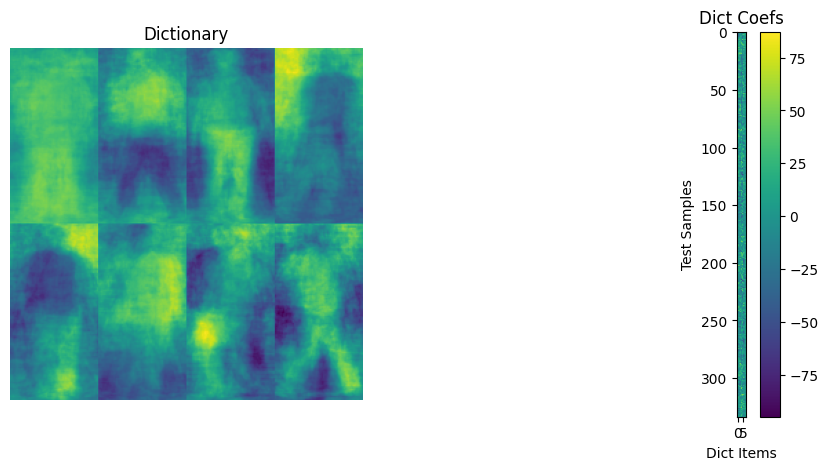

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im = ax[0].imshow(I)
ax[0].set_title('Dictionary')
ax[0].axis('off')
im = ax[1].imshow(x)
ax[1].set_xlabel('Dict Items')
ax[1].set_ylabel('Test Samples')
ax[1].set_title('Dict Coefs')
fig.colorbar(im, fraction=0.07, pad=0.04)

In [14]:
def sci(x):
    # x -> [n, k]
    k = x.shape[1]
    l1 = np.linalg.norm(x, ord=1, axis=-1)
    return (k * np.max(np.abs(x), axis=-1) / l1 - 1) / (k - 1)

Text(0, 0.5, 'SCI')

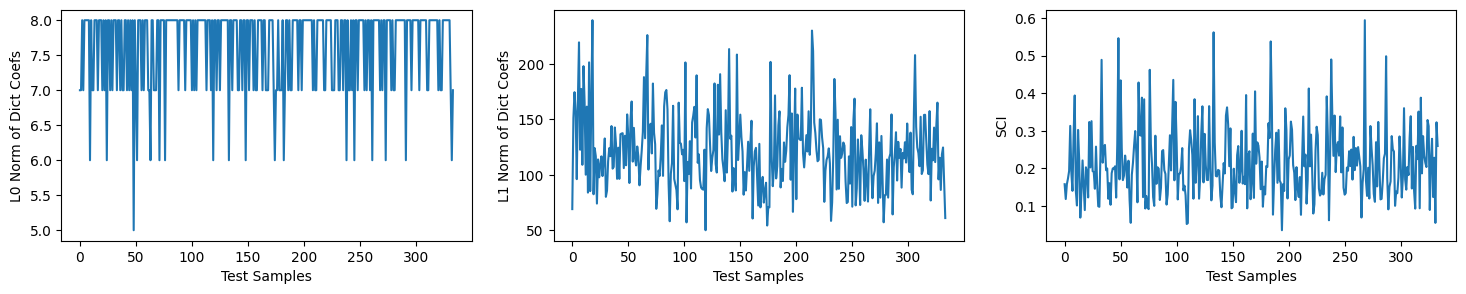

In [15]:
l0 = np.linalg.norm(x, ord=0, axis=1)
l1 = np.linalg.norm(x, ord=1, axis=1)
s = sci(x)

fig, ax = plt.subplots(1, 3, figsize=(18, 3))

ax[0].plot(l0)
ax[0].set_xlabel('Test Samples')
ax[0].set_ylabel('L0 Norm of Dict Coefs')
ax[1].plot(l1)
ax[1].set_xlabel('Test Samples')
ax[1].set_ylabel('L1 Norm of Dict Coefs')
ax[2].plot(s)
ax[2].set_xlabel('Test Samples')
ax[2].set_ylabel('SCI')

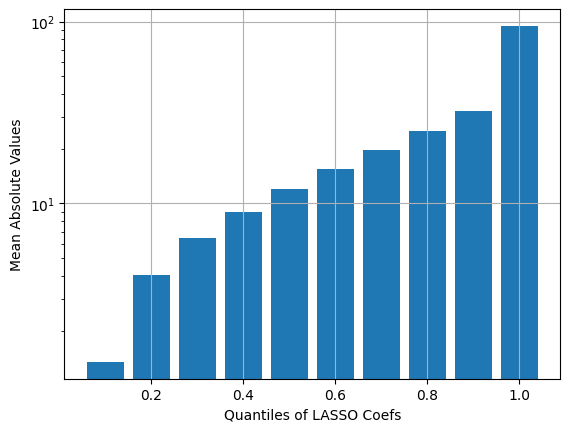

In [16]:
qs = np.arange(0.1, 1.1, 0.1)
c = []
for q in qs:
    c.append(np.quantile(np.abs(x), q))
plt.bar(qs, c, width=0.08)
plt.yscale('log')
plt.xlabel('Quantiles of LASSO Coefs')
plt.ylabel('Mean Absolute Values')
plt.grid('on')

In [17]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# im = ax[0].imshow(I)
# ax[0].set_title('Dictionary')
# ax[0].axis('off')
# xs = np.where(x > c[-2], x, 0)
# im = ax[1].imshow(xs)
# ax[1].set_xlabel('Dict Items')
# ax[1].set_ylabel('Test Samples')
# ax[1].set_title('Dict Coefs')
# fig.colorbar(im, fraction=0.07, pad=0.04)

In [18]:
# l0 = np.linalg.norm(xs, ord=0, axis=1)
# l1 = np.linalg.norm(xs, ord=1, axis=1)
# ss = sci(xs + 1e-8)

# fig, ax = plt.subplots(1, 3, figsize=(15, 3))

# ax[0].plot(l0)
# ax[0].set_xlabel('Test Samples')
# ax[0].set_ylabel('L0 Norm of LASSO Coefs')
# ax[1].plot(l1)
# ax[1].set_xlabel('Test Samples')
# ax[1].set_ylabel('L1 Norm of LASSO Coefs')
# ax[2].plot(ss)
# ax[2].set_xlabel('Test Samples')
# ax[2].set_ylabel('SCI')

In [23]:
def show_topk(i, k):
    ids = np.argsort(np.abs(x[i]))[::-1][:k]
    title = '{}{} ({})\n{}'.format(
        typeof(yl[i]), idof(yl[i]), 'occluded' if is_occluded(yl[i]) else 'not occluded',
        'carry-on: ' + carry_ons(yl[i])
    )
    r = 2
    c = (k + 1) // 2
    fig, ax = plt.subplots(r, c, figsize=(c*3, 9))
    ax[0][0].imshow(y[i].reshape(*D.shape[-2:]))
    ax[0][0].axis('off')
    ax[0][0].set_title(title + '\nSCI = {:.3f}'.format(s[i]))
    for j, ii in enumerate(ids):
        # title = '{}{} ({})\n{}'.format(
        #     typeof(Dl[ii]), idof(Dl[ii]), 'occluded' if is_occluded(Dl[ii]) else 'not occluded',
        #     'carry-on: ' + carry_ons(Dl[ii])
        # )
        ax[(j+1)//c][(j+1)%c].imshow(C[ii].reshape(*D.shape[-2:]))
        ax[(j+1)//c][(j+1)%c].axis('off')
        # ax[(j+1)//c][(j+1)%c].set_title(title + '\nCoef = {:.3f}'.format(x[i, ii]))

In [24]:
ids = np.argsort(s)[-5:]
ids, l1[ids], l0[ids], s[ids]

(array([287, 184,  48, 133, 268]),
 array([106.82872578, 144.65930698, 108.69344506, 138.76011118,
         79.02382498]),
 array([8., 8., 5., 6., 7.]),
 array([0.49832741, 0.53774983, 0.54635841, 0.56196292, 0.59418832]))

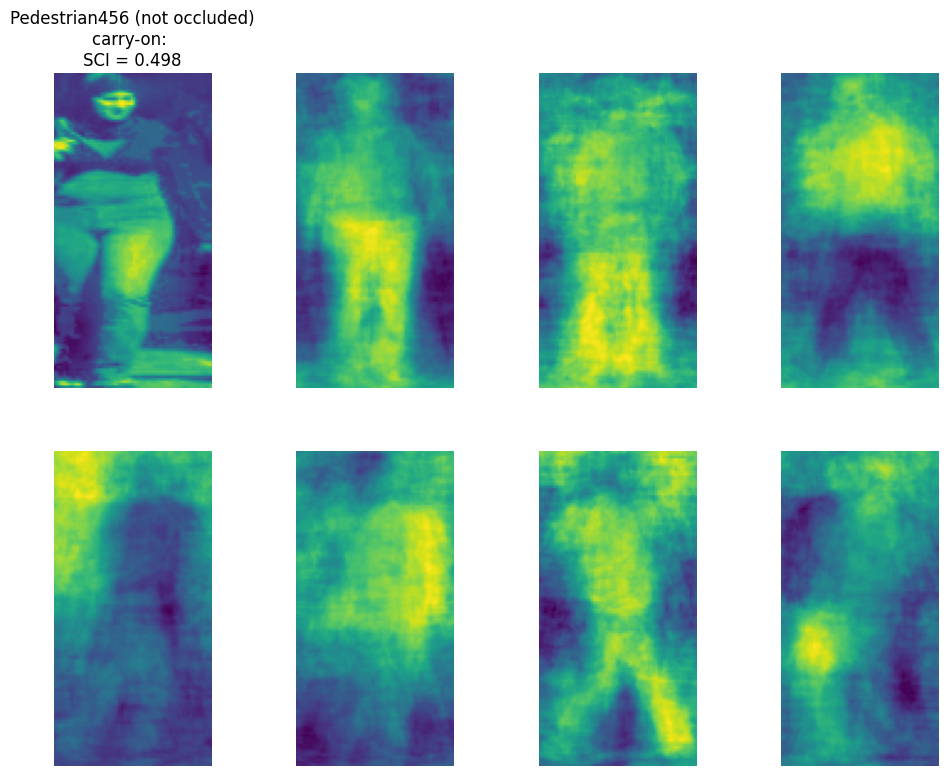

In [25]:
show_topk(287, k=7)

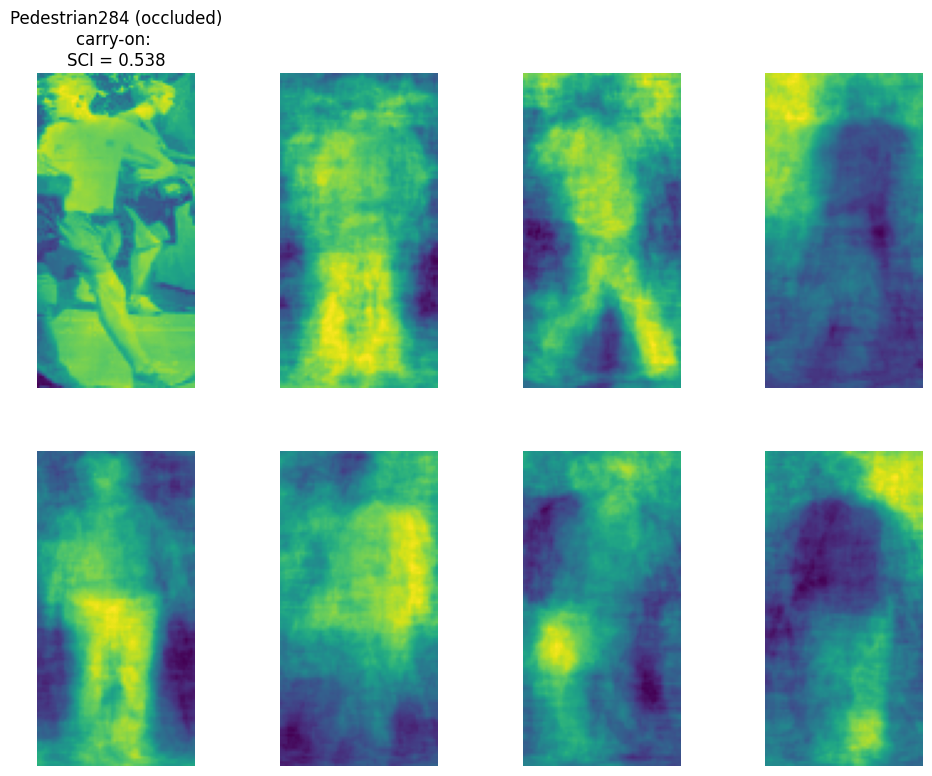

In [26]:
show_topk(184, k=7)

In [28]:
ids = np.argsort(s)[:5]
ids, l1[ids], l0[ids], s[ids]

(array([194, 109, 110, 331,  59]),
 array([189.92039763, 161.37556861, 133.70351514, 124.73923825,
        116.7893778 ]),
 array([8., 8., 8., 7., 8.]),
 array([0.03568351, 0.05223739, 0.05454481, 0.05523283, 0.05538588]))

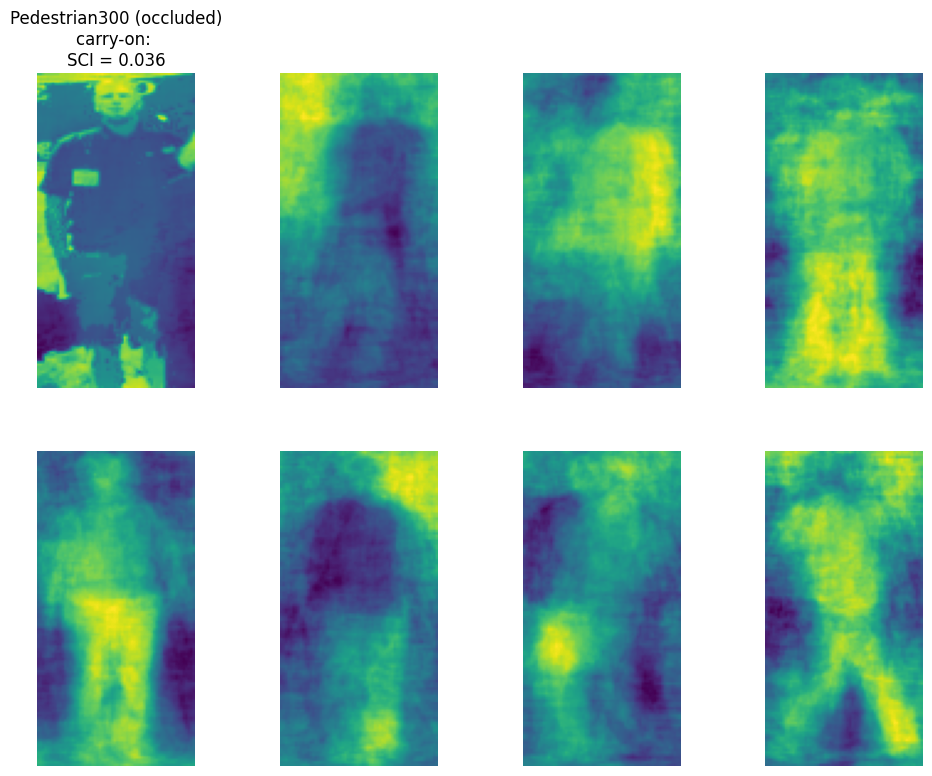

In [29]:
show_topk(194, k=7)

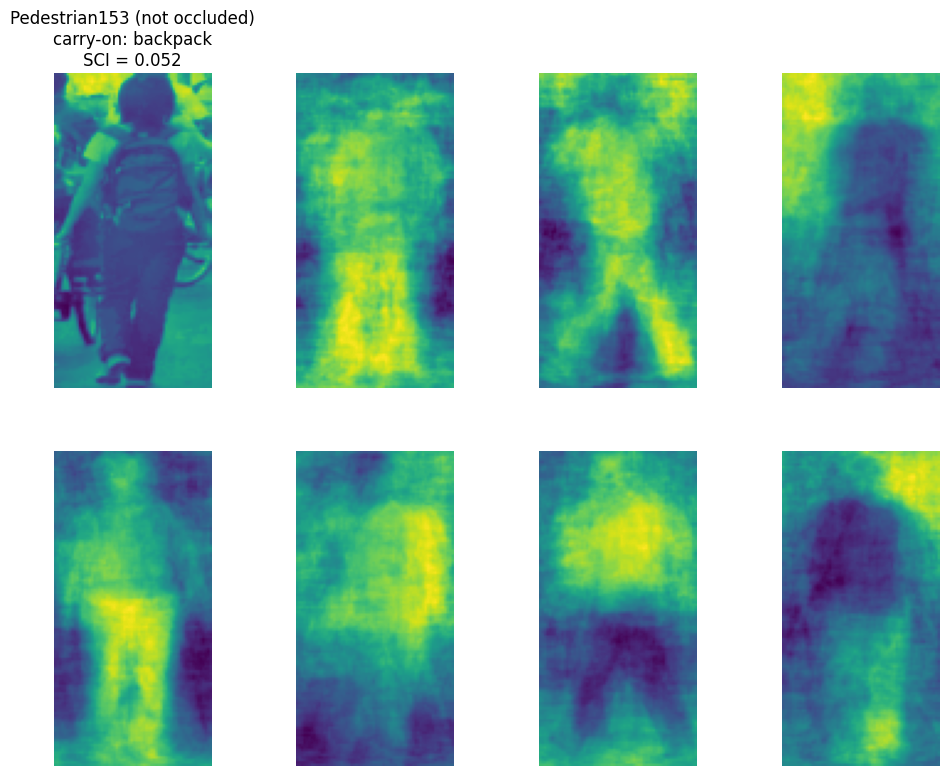

In [30]:
show_topk(109, k=7)

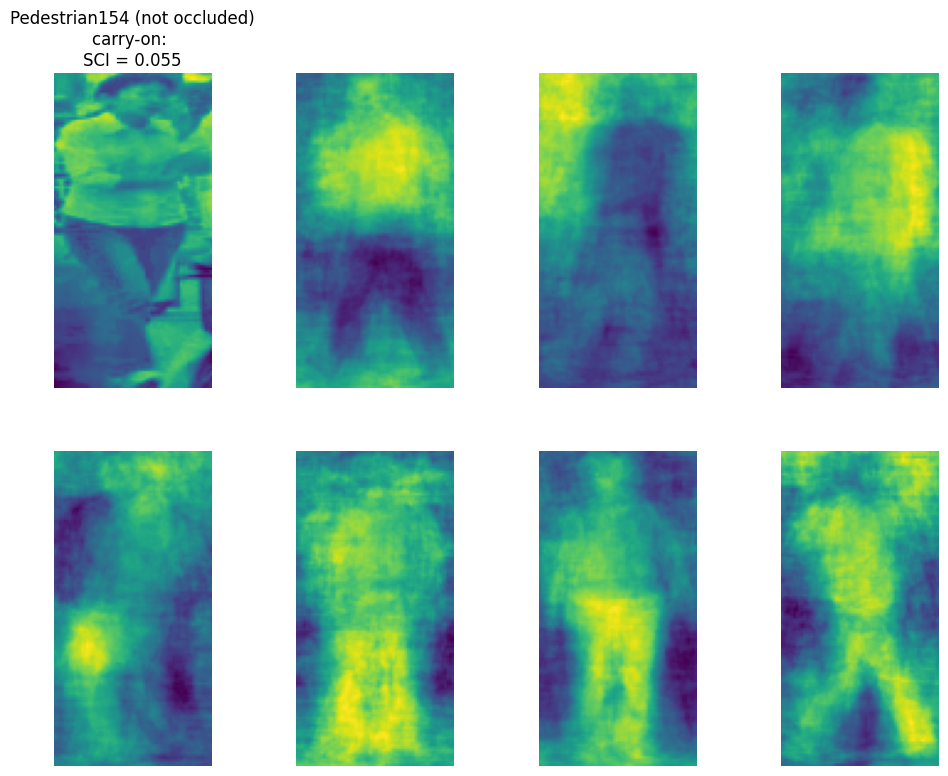

In [31]:
show_topk(110, k=7)

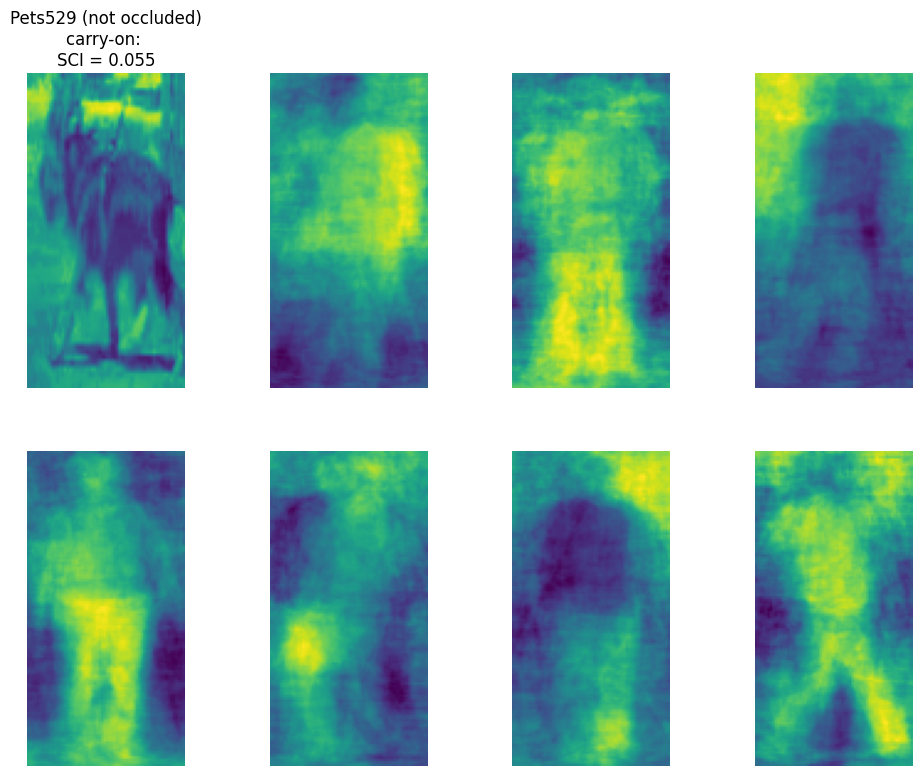

In [32]:
show_topk(331, k=7)

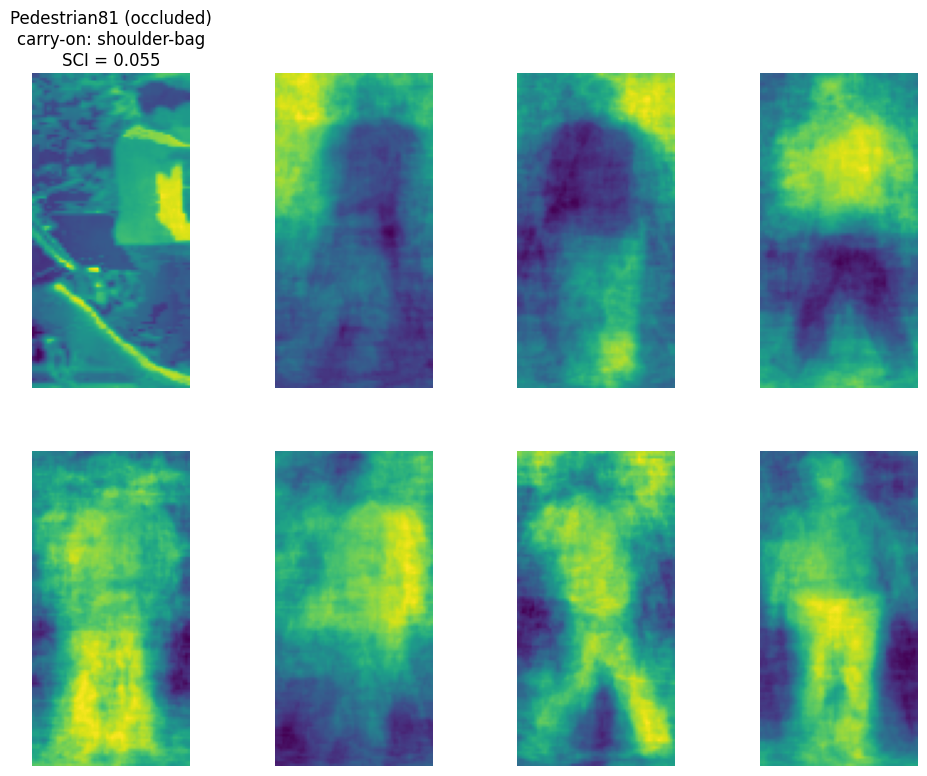

In [33]:
show_topk(59, k=7)

### Feat

In [70]:
root = 'PennFudanPed/ViaCropsNOC/'

D = np.load(root + 'train_dict.npy')
y = np.load(root + 'test_dict.npy')
Dl = np.load(root + 'train_labels.npy')
yl = np.load(root + 'test_labels.npy')
Df = np.load(root + 'train_feats.npy')
yf = np.load(root + 'test_feats.npy')

D.shape, y.shape, Dl.shape, yl.shape, Df.shape, yf.shape

((200, 128, 64), (334, 128, 64), (200, 9), (334, 9), (200, 2048), (334, 2048))

**Slow!**

In [82]:
dim = 2048
dict_learner = DictionaryLearning(
    n_components=8, transform_algorithm='lasso_lars',
    transform_alpha=1e-1,
).fit(Df.reshape(-1, dim))

In [83]:
x = dict_learner.transform(yf.reshape(-1, dim))
x.shape

(334, 8)

In [84]:
C = dict_learner.components_#.reshape(-1, 128, 64)
C.shape

(8, 2048)

In [85]:
# I = np.zeros((128 * 2, 64 * 4))
# for i in range(2):
#     for j in range(4):
#         I[i*128:(i+1)*128, j*64:(j+1)*64] = C[i*4+j]
# I.shape

In [86]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# im = ax[0].imshow(I)
# ax[0].set_title('Dictionary')
# ax[0].axis('off')
# im = ax[1].imshow(x)
# ax[1].set_xlabel('Dict Items')
# ax[1].set_ylabel('Test Samples')
# ax[1].set_title('Dict Coefs')
# fig.colorbar(im, fraction=0.07, pad=0.04)

In [87]:
def sci(x):
    # x -> [n, k]
    k = x.shape[1]
    l1 = np.linalg.norm(x, ord=1, axis=-1)
    return ((k * np.max(np.abs(x), axis=-1) + 1e-8) / (l1 + 1e-8) - 1) / (k - 1)

Text(0, 0.5, 'SCI')

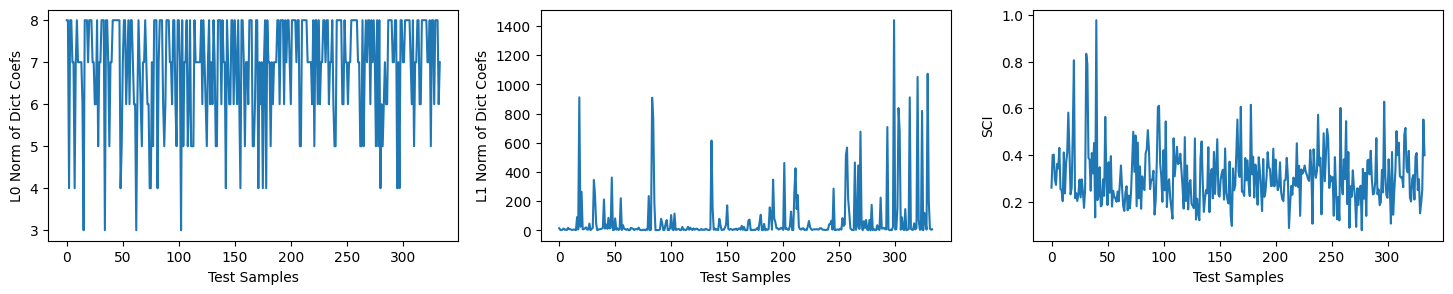

In [88]:
l0 = np.linalg.norm(x, ord=0, axis=1)
l1 = np.linalg.norm(x, ord=1, axis=1)
s = sci(x)

fig, ax = plt.subplots(1, 3, figsize=(18, 3))

ax[0].plot(l0)
ax[0].set_xlabel('Test Samples')
ax[0].set_ylabel('L0 Norm of Dict Coefs')
ax[1].plot(l1)
ax[1].set_xlabel('Test Samples')
ax[1].set_ylabel('L1 Norm of Dict Coefs')
ax[2].plot(s)
ax[2].set_xlabel('Test Samples')
ax[2].set_ylabel('SCI')

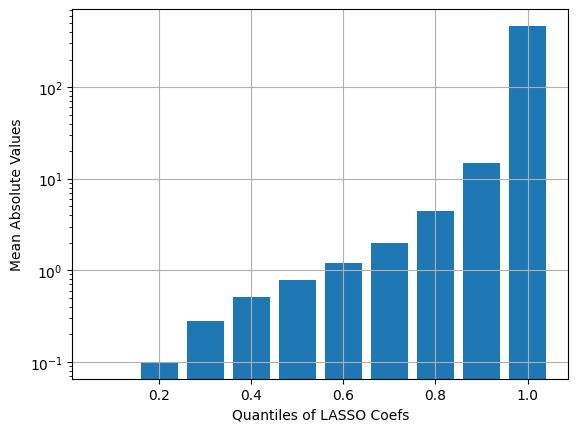

In [89]:
qs = np.arange(0.1, 1.1, 0.1)
c = []
for q in qs:
    c.append(np.quantile(np.abs(x), q))
plt.bar(qs, c, width=0.08)
plt.yscale('log')
plt.xlabel('Quantiles of LASSO Coefs')
plt.ylabel('Mean Absolute Values')
plt.grid('on')

In [90]:
ids = np.argsort(s)[-5:]
ids, l1[ids], l0[ids], s[ids]

(array([297,  32,  20,  31,  40]),
 array([  1.0603096, 242.12076  , 264.61176  , 345.27313  , 211.64417  ],
       dtype=float32),
 array([4., 8., 8., 8., 7.], dtype=float32),
 array([0.6280485 , 0.7900699 , 0.80554694, 0.8332716 , 0.9768985 ],
       dtype=float32))

[ -0.8854054   1.4466261 141.45953   -14.580553  -22.4068     12.0521965
  -3.6585376  20.69194  ]
[-0.7561209  -0.38502073 28.79166    -5.979149   -0.77221656 -1.4794741
  1.6036454   4.1640134 ]
[ 1.5087755 -0.7453297 44.55429   -4.3688664 -5.34066    1.448877
  2.8940754  7.0744905]
[13.411293   46.571323   -1.8268658  -3.456874    0.17199078  0.18156528
 -4.0030184  -1.0170223 ]
[ 0.          0.37255323  0.         -0.05534514  1.3500123   0.2583114
  0.          0.        ]
[ 0.09131916  0.          0.         -0.20244062  0.05132609  0.71522385
  0.          0.        ]
[ 16.471058  197.64587    -5.101001   -6.06454    -3.059002    3.763456
  -8.841431    1.1744059]
[ 17.9187    219.58902    -4.5986094  -7.15237    -2.3003893   3.0696044
  -9.4727545   0.5103022]
[ 1.8641827e+01  2.9490216e+02 -5.6714530e+00 -9.7409420e+00
  2.1442088e-01  5.7952809e+00 -9.6834917e+00 -6.2357986e-01]
[  0.24992254 207.36603     -0.8825511   -1.9458437    0.
  -0.34647503  -0.38791865  -0.46541873

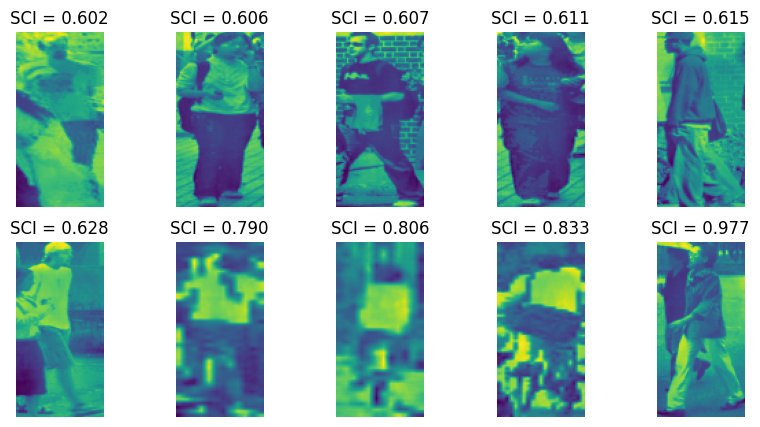

In [91]:
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for ii, i in enumerate(np.argsort(s)[-10:]):
    ax[ii//5][ii%5].imshow(y[i])
    ax[ii//5][ii%5].axis('off')
    ax[ii//5][ii%5].set_title('SCI = {:.3f}'.format(s[i]))
    print(x[i])

[  9.34241     4.9267416   4.3863077 -12.8632145 -11.03224    13.815582
  12.156559    2.8514106]
[  9.672658   8.524021  14.294934 -29.437187 -15.69355   23.971802
  24.511026  19.750034]
[ 4.0515714  0.        -2.7188587 -6.8599577  5.8092794  4.5597844
  4.646569   5.2007546]
[12.971876   0.9053529 12.668307  -6.463154  12.802042   5.5599546
  8.107309   3.4803267]
[ 2.657729   1.4952049  2.9692163 -2.0260458  1.7490034 -1.5374739
  0.         1.7266414]
[ 3.0612724   0.34920382  2.9265115  -3.2670465   1.6580989   0.6537588
 -1.4203368   1.6633191 ]
[182.92665   10.5968   133.22348   62.414207  57.963154 151.61021
 146.23784   92.88676 ]
[130.52068     6.1524653 125.736824   33.709686   71.07256    84.29182
  39.119137   76.34997  ]
[-0.23247688  0.         -0.90580666 -1.1259158   1.2828677   0.64601964
  1.3460249   0.28812018]
[ 1.1250443   0.          1.13626    -0.49624524  1.1993088   0.26869145
  0.23226848 -0.6768677 ]


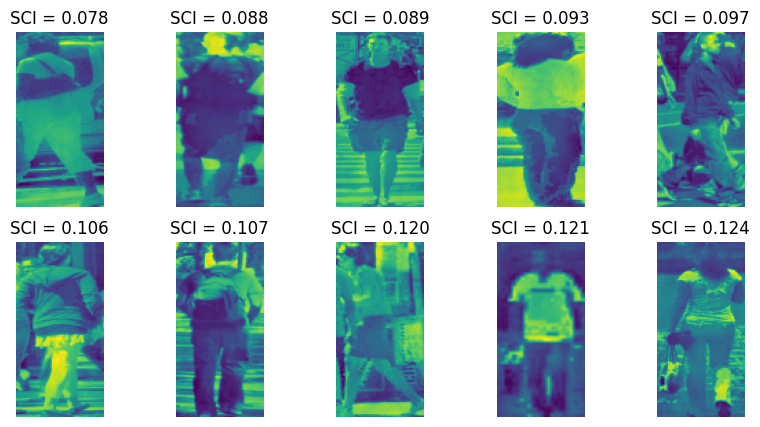

In [92]:
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for ii, i in enumerate(np.argsort(s)[:10]):
    ax[ii//5][ii%5].imshow(y[i])
    ax[ii//5][ii%5].axis('off')
    ax[ii//5][ii%5].set_title('SCI = {:.3f}'.format(s[i]))
    print(x[i])

In [17]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# im = ax[0].imshow(I)
# ax[0].set_title('Dictionary')
# ax[0].axis('off')
# xs = np.where(x > c[-2], x, 0)
# im = ax[1].imshow(xs)
# ax[1].set_xlabel('Dict Items')
# ax[1].set_ylabel('Test Samples')
# ax[1].set_title('Dict Coefs')
# fig.colorbar(im, fraction=0.07, pad=0.04)

In [18]:
# l0 = np.linalg.norm(xs, ord=0, axis=1)
# l1 = np.linalg.norm(xs, ord=1, axis=1)
# ss = sci(xs + 1e-8)

# fig, ax = plt.subplots(1, 3, figsize=(15, 3))

# ax[0].plot(l0)
# ax[0].set_xlabel('Test Samples')
# ax[0].set_ylabel('L0 Norm of LASSO Coefs')
# ax[1].plot(l1)
# ax[1].set_xlabel('Test Samples')
# ax[1].set_ylabel('L1 Norm of LASSO Coefs')
# ax[2].plot(ss)
# ax[2].set_xlabel('Test Samples')
# ax[2].set_ylabel('SCI')

In [23]:
def show_topk(i, k):
    ids = np.argsort(np.abs(x[i]))[::-1][:k]
    title = '{}{} ({})\n{}'.format(
        typeof(yl[i]), idof(yl[i]), 'occluded' if is_occluded(yl[i]) else 'not occluded',
        'carry-on: ' + carry_ons(yl[i])
    )
    r = 2
    c = (k + 1) // 2
    fig, ax = plt.subplots(r, c, figsize=(c*3, 9))
    ax[0][0].imshow(y[i].reshape(*D.shape[-2:]))
    ax[0][0].axis('off')
    ax[0][0].set_title(title + '\nSCI = {:.3f}'.format(s[i]))
    for j, ii in enumerate(ids):
        # title = '{}{} ({})\n{}'.format(
        #     typeof(Dl[ii]), idof(Dl[ii]), 'occluded' if is_occluded(Dl[ii]) else 'not occluded',
        #     'carry-on: ' + carry_ons(Dl[ii])
        # )
        ax[(j+1)//c][(j+1)%c].imshow(C[ii].reshape(*D.shape[-2:]))
        ax[(j+1)//c][(j+1)%c].axis('off')
        # ax[(j+1)//c][(j+1)%c].set_title(title + '\nCoef = {:.3f}'.format(x[i, ii]))

In [24]:
ids = np.argsort(s)[-5:]
ids, l1[ids], l0[ids], s[ids]

(array([287, 184,  48, 133, 268]),
 array([106.82872578, 144.65930698, 108.69344506, 138.76011118,
         79.02382498]),
 array([8., 8., 5., 6., 7.]),
 array([0.49832741, 0.53774983, 0.54635841, 0.56196292, 0.59418832]))

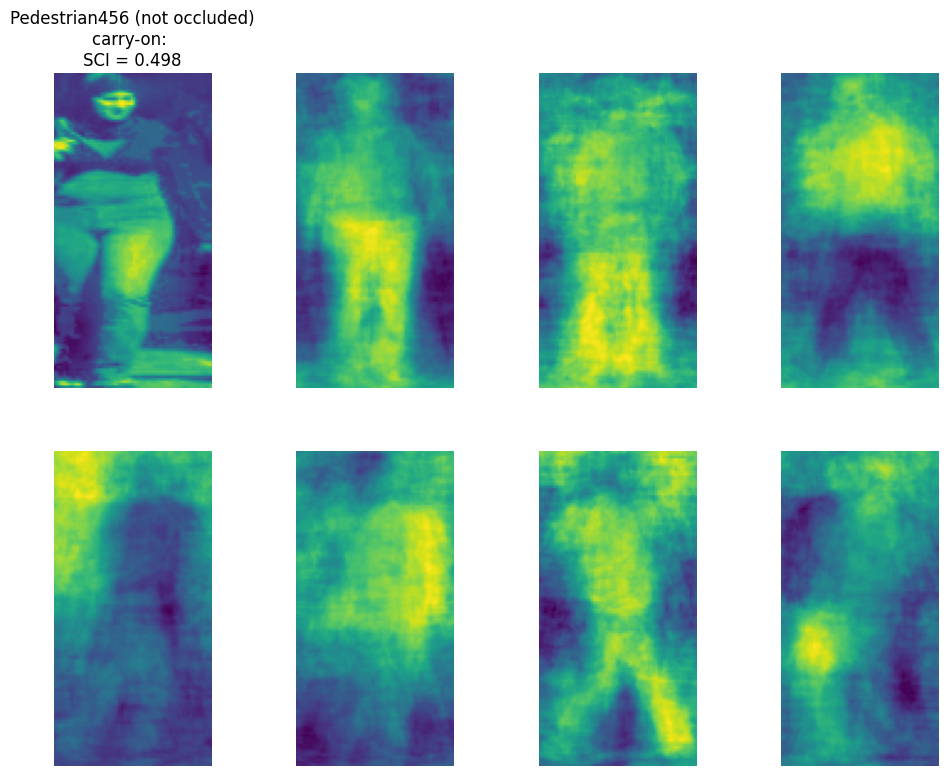

In [25]:
show_topk(287, k=7)

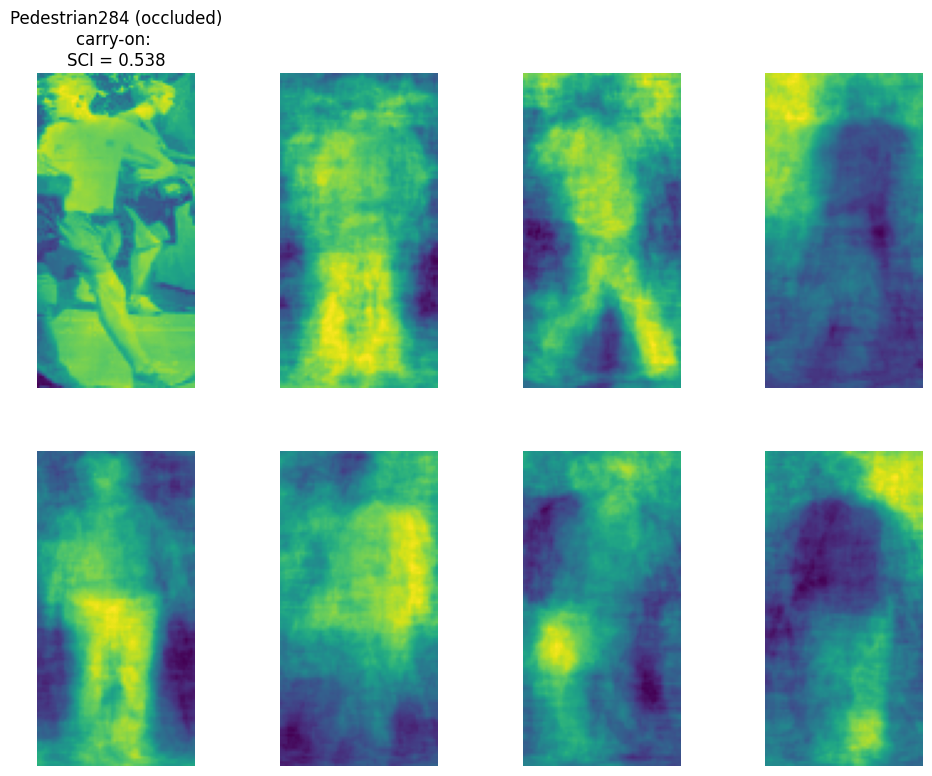

In [26]:
show_topk(184, k=7)

In [28]:
ids = np.argsort(s)[:5]
ids, l1[ids], l0[ids], s[ids]

(array([194, 109, 110, 331,  59]),
 array([189.92039763, 161.37556861, 133.70351514, 124.73923825,
        116.7893778 ]),
 array([8., 8., 8., 7., 8.]),
 array([0.03568351, 0.05223739, 0.05454481, 0.05523283, 0.05538588]))

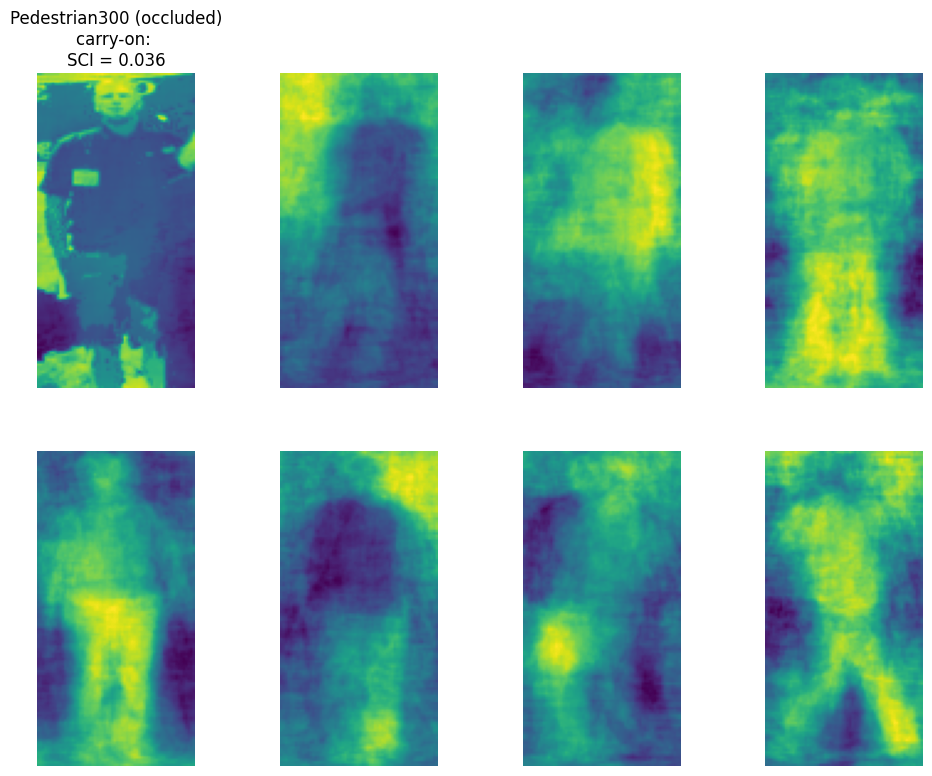

In [29]:
show_topk(194, k=7)

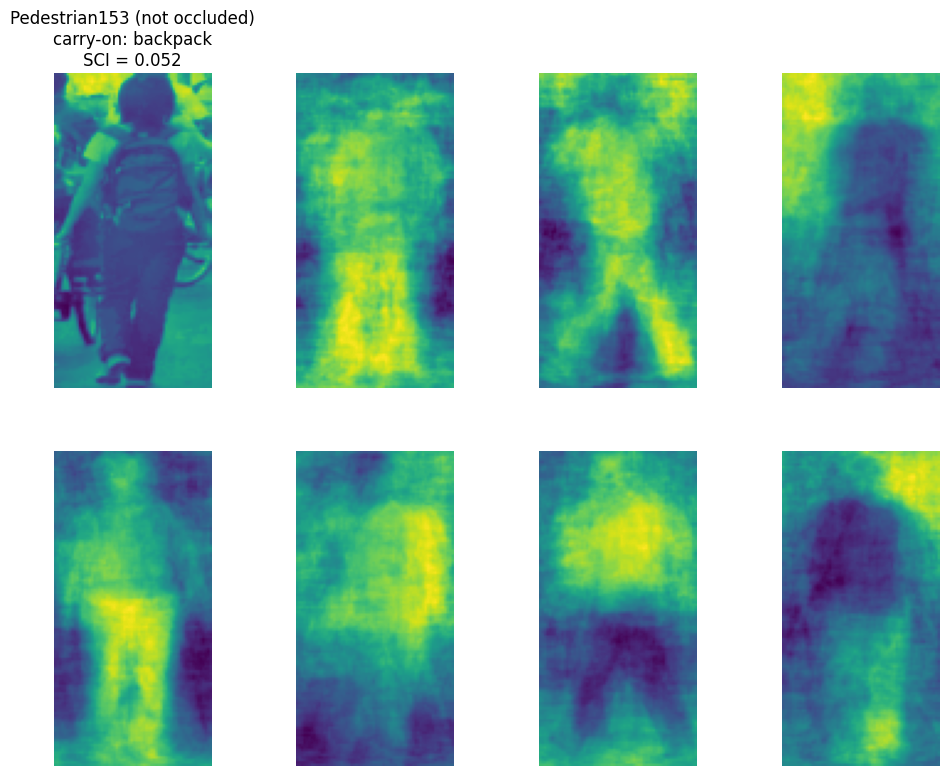

In [30]:
show_topk(109, k=7)

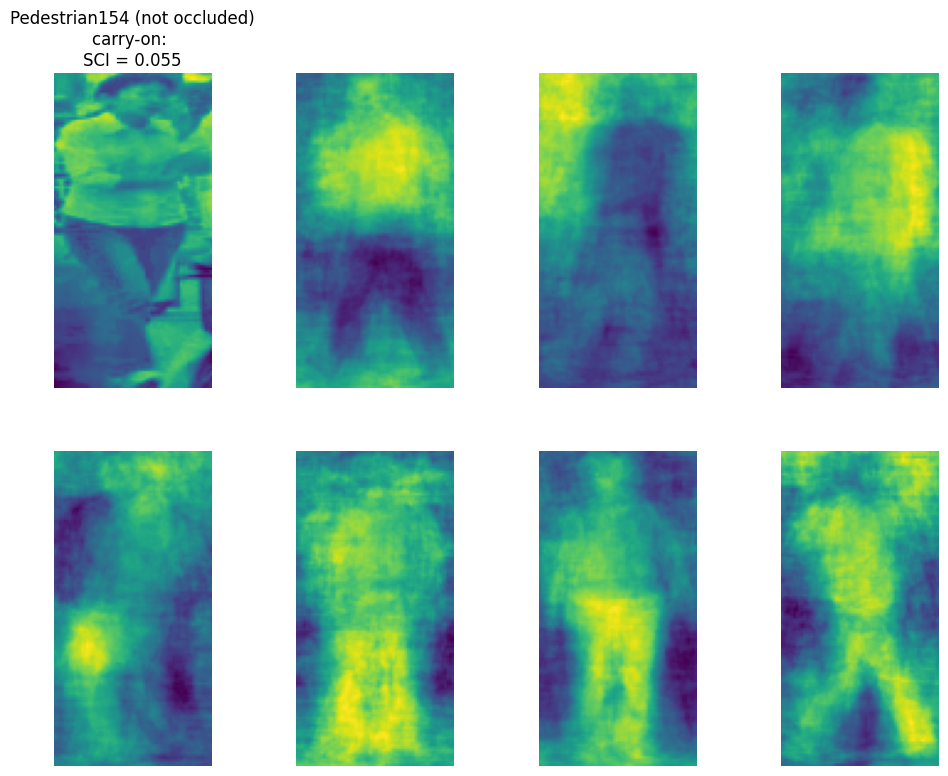

In [31]:
show_topk(110, k=7)

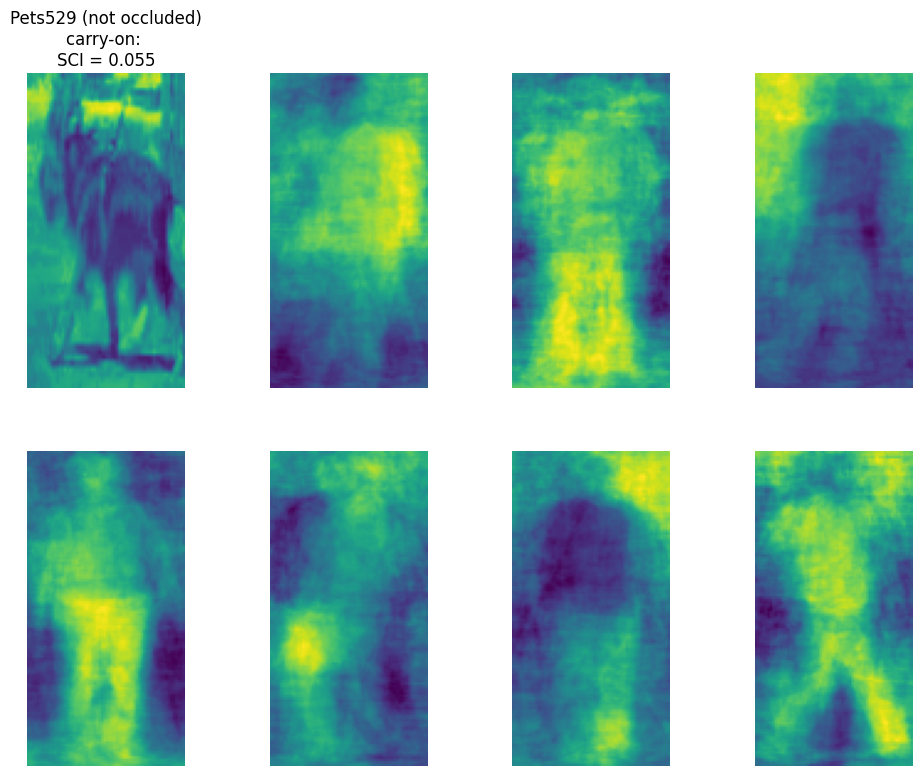

In [32]:
show_topk(331, k=7)

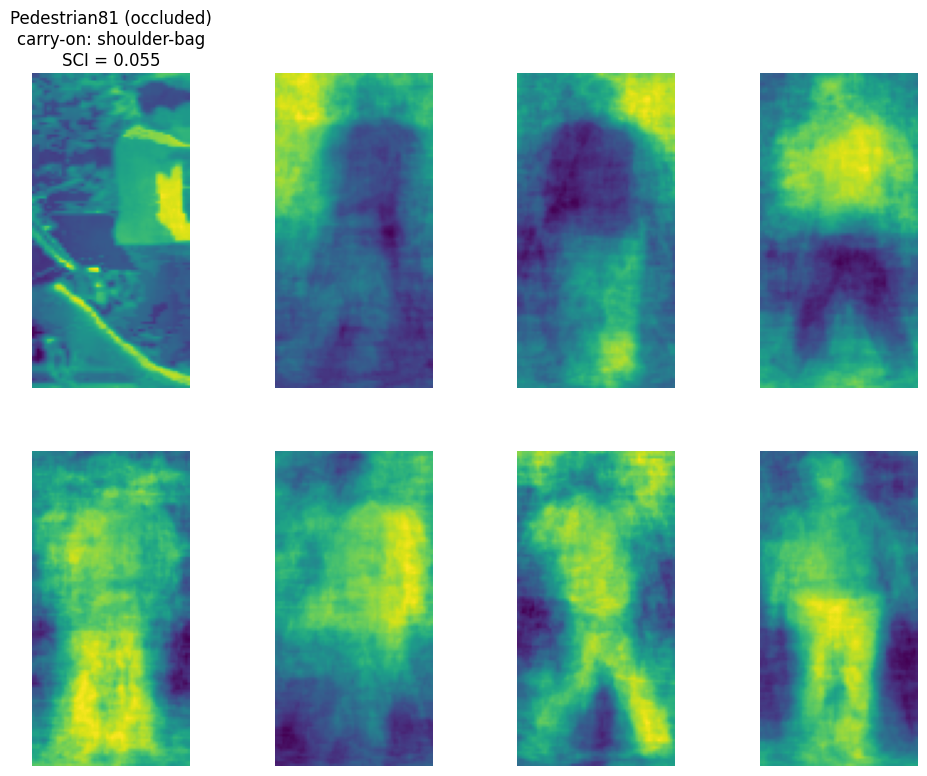

In [33]:
show_topk(59, k=7)

## Two Dicts

In [93]:
Dp = np.load('PennFudanPed/Dict/all_pedestrians.npy')
Dc = np.load('PennFudanPed/Dict/all_cyclists.npy')

Dp.shape, Dc.shape

((511, 128, 64), (22, 128, 64))

In [128]:
ids_peds = np.random.choice(range(len(Dp)), 50, replace=False)
Dp_train = Dp[ids_peds[:-10]]
Dp_test = Dp[ids_peds[-10:]]
Dp_train.shape, Dp_test.shape

((40, 128, 64), (10, 128, 64))

In [129]:
ids_cycs = np.random.choice(range(len(Dc)), 20, replace=False)
Dc_train = Dp[ids_cycs[:-10]]
Dc_test = Dc[ids_cycs[-10:]]
Dc_train.shape, Dc_test.shape

((10, 128, 64), (10, 128, 64))

In [130]:
Dt = np.vstack([Dp_test, Dc_test])
Dt.shape

(20, 128, 64)

In [131]:
dim = 128 * 64
dict_ped = DictionaryLearning(
    n_components=2, transform_algorithm='lasso_lars',
    transform_alpha=1e-2,
).fit(Dp_train.reshape(-1, dim))
dict_cyc = DictionaryLearning(
    n_components=2, transform_algorithm='lasso_lars',
    transform_alpha=1e-2,
).fit(Dc_train.reshape(-1, dim))

In [132]:
xp = dict_ped.transform(Dt.reshape(-1, dim))
xc = dict_cyc.transform(Dt.reshape(-1, dim))
xp.shape, xc.shape

((20, 2), (20, 2))

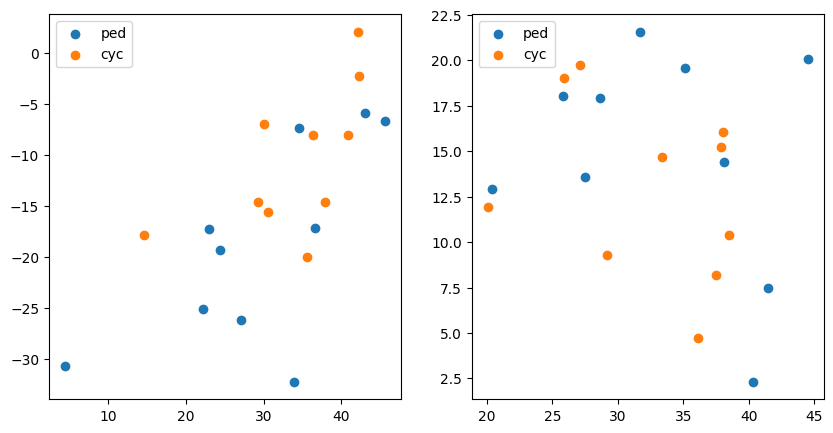

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(xp[:10, 0], xp[:10, 1], label='ped')
ax[0].scatter(xp[10:, 0], xp[10:, 1], label='cyc')
ax[0].legend()

ax[1].scatter(xc[:10, 0], xc[:10, 1], label='ped')
ax[1].scatter(xc[10:, 0], xc[10:, 1], label='cyc')
ax[1].legend()